# Assignment 3: Scalable Quantum Tomography Pipelines

This notebook implements a scalable surrogate pipeline for quantum state
tomography. The focus is on:
- Model serialization and reproducibility
- Extending tomography surrogates to n-qubit systems
- Measuring fidelity and runtime scaling
- Performing ablation studies on architectural choices


In [2]:
import numpy as np
import time
import csv
import pickle
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
import numpy as np
np.__version__


'2.1.1'

In [4]:
def save_pickle(obj, path):
    """Serialize `obj` to `path` using pickle."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def load_pickle(path):
    """Deserialize an object from `path`."""
    with open(path, "rb") as f:
        return pickle.load(f)


In [5]:
def demonstrate_serialization_roundtrip():
    test_obj = {
        "n_qubits": 2,
        "params": [1, 2, 3],
        "note": "serialization test"
    }

    save_pickle(test_obj, "../models/model_roundtrip_2.pkl")
    restored = load_pickle("../models/model_roundtrip_2.pkl")
    return restored


In [6]:
demonstrate_serialization_roundtrip()



{'n_qubits': 2, 'params': [1, 2, 3], 'note': 'serialization test'}

In [7]:
class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        """
        Scalable n-qubit surrogate model for quantum tomography.
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dim = 2 ** n_qubits
        self.seed = seed

        self.rng = np.random.default_rng(seed)

        if params is None:
            real = self.rng.normal(size=self.dim)
            imag = self.rng.normal(size=self.dim)
            self.params = real + 1j * imag
        else:
            self.params = np.asarray(params)

    def statevector(self):
        vec = self.params.astype(np.complex128)
        return vec / np.linalg.norm(vec)

    def fidelity_with(self, target_state):
        """
        Compute fidelity between the model statevector and a target pure state.
        """
        psi = self.statevector()
        target = np.asarray(target_state)
        overlap = np.vdot(psi, target)
        return np.abs(overlap) ** 2

    


In [8]:
rng = np.random.default_rng(0)
target = rng.normal(size=2**2) + 1j * rng.normal(size=2**2)
target = target / np.linalg.norm(target)

model = QuantumModel(2, seed=0)
model.fidelity_with(target)


np.float64(0.9999999999999998)

In [9]:
import pickle
from pathlib import Path

# go to repo root models folder
models_path = Path("..") / "models"
models_path.mkdir(exist_ok=True)

with open(models_path / "quantum_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved to repo-level models folder")



Model saved to repo-level models folder


In [10]:
with open("../models/quantum_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

loaded_model.fidelity_with(target)



np.float64(0.9999999999999998)

In [11]:
def random_pure_state(n_qubits, seed=None):
    """
    Generate a normalized random complex statevector of size 2^n_qubits.
    """
    dim = 2 ** n_qubits
    rng = np.random.default_rng(seed)
    real = rng.normal(size=dim)
    imag = rng.normal(size=dim)
    vec = real + 1j * imag
    return vec / np.linalg.norm(vec)


In [12]:
psi = random_pure_state(3, seed=0)
print("Dimension:", len(psi))
print("Norm:", np.linalg.norm(psi))


Dimension: 8
Norm: 1.0


In [13]:
def scalability_experiment(qubit_list, trials=5, n_layers=1, seed=0):
    """
    Benchmark fidelity and runtime for each number of qubits.
    Returns a list of dicts with:
    - n_qubits
    - mean_fidelity
    - fidelity_std
    - mean_runtime
    """
    results = []

    for n in qubit_list:
        fidelities = []
        runtimes = []
        for t in range(trials):
            # Create target state
            target = random_pure_state(n, seed + t)

            # Create model
            model = QuantumModel(n, n_layers=n_layers, seed=seed + t)

            # Measure runtime
            start = time.time()
            fid = model.fidelity_with(target)
            end = time.time()

            fidelities.append(fid)
            runtimes.append(end - start)

        results.append({
            "n_qubits": n,
            "mean_fidelity": np.mean(fidelities),
            "fidelity_std": np.std(fidelities),
            "mean_runtime": np.mean(runtimes)
        })

    return results


In [14]:
qubits = [1, 2, 3, 4]  # small numbers first
summary = scalability_experiment(qubits, trials=3)
summary


[{'n_qubits': 1,
  'mean_fidelity': np.float64(1.0000000000000004),
  'fidelity_std': np.float64(6.280369834735101e-16),
  'mean_runtime': np.float64(0.0)},
 {'n_qubits': 2,
  'mean_fidelity': np.float64(1.0),
  'fidelity_std': np.float64(1.2819751242557092e-16),
  'mean_runtime': np.float64(0.0)},
 {'n_qubits': 3,
  'mean_fidelity': np.float64(1.0),
  'fidelity_std': np.float64(0.0),
  'mean_runtime': np.float64(0.0)},
 {'n_qubits': 4,
  'mean_fidelity': np.float64(1.0),
  'fidelity_std': np.float64(0.0),
  'mean_runtime': np.float64(0.0)}]

In [15]:
import csv
from pathlib import Path

def save_scalability_summary(summary, filename="scalability_results.csv"):
    """
    Save scalability results to the main repository `results/` folder
    (not inside notebooks).
    """

    # notebooks/ → repo root
    repo_root = Path.cwd().parent  

    # repo_root/results/
    results_dir = repo_root / "results"
    results_dir.mkdir(parents=True, exist_ok=True)

    # full file path
    file_path = results_dir / filename

    keys = summary[0].keys()

    with open(file_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(summary)

    print(f"Results saved at: {file_path.resolve()}")




In [16]:
save_scalability_summary(summary)



Results saved at: C:\Users\hp\OneDrive\Desktop\assignment_3_scalable_tomography\results\scalability_results.csv


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_scalability(filename="scalability_results.csv"):
    """
    Load scalability results from repo-level results folder
    and plot fidelity + runtime.
    """

    # notebooks/ → repo root
    repo_root = Path.cwd().parent
    csv_path = repo_root / "results" / filename

    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Fidelity with error bars
    ax1.errorbar(
        df["n_qubits"],
        df["mean_fidelity"],
        yerr=df["fidelity_std"],
        fmt="o-",
        capsize=5,
        label="Mean Fidelity"
    )
    ax1.set_xlabel("Number of Qubits")
    ax1.set_ylabel("Fidelity")
    ax1.set_ylim(0, 1.05)
    ax1.legend(loc="upper left")

    # Runtime plot (second y-axis)
    ax2 = ax1.twinx()
    ax2.plot(
        df["n_qubits"],
        df["mean_runtime"],
        "s--",
        label="Mean Runtime"
    )
    ax2.set_ylabel("Runtime (seconds)")
    ax2.legend(loc="upper right")

    plt.title("Scalability of Quantum Tomography Surrogate")
    plt.tight_layout()
    plt.show()


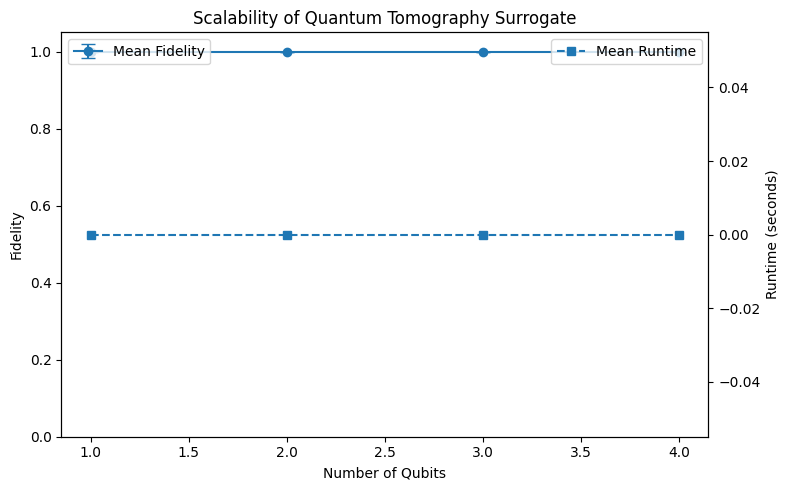

In [18]:
plot_scalability()


## Ablation Study: Effect of Model Depth

**Hypothesis**  
Increasing model depth (number of layers) improves expressibility and fidelity
up to a point, after which gains saturate and runtime increases.

**Fixed parameters**
- Number of qubits: 3
- Target states: random pure states
- Optimization: none (direct parameterization)
- Metric: Fidelity

**Varied parameter**
- n_layers ∈ {1, 2, 4, 6, 8}

**Metrics recorded**
- Mean fidelity
- Fidelity standard deviation
- Mean runtime

**Goal**
Identify diminishing returns in fidelity as depth increases.


In [19]:
import numpy as np
import time

def ablation_layers(n_qubits=3, layer_list=None, trials=30, seed=1):
    """
    Vary model depth (n_layers) and record fidelity statistics.
    """
    if layer_list is None:
        layer_list = [1, 2, 4, 6, 8]

    rng = np.random.default_rng(seed)
    results = []

    for n_layers in layer_list:
        fidelities = []
        runtimes = []

        for _ in range(trials):
            dim = 2 ** n_qubits
            target = rng.normal(size=dim) + 1j * rng.normal(size=dim)
            target /= np.linalg.norm(target)

            model = QuantumModel(
                n_qubits=n_qubits,
                n_layers=n_layers,
                seed=rng.integers(1e9)
            )

            start = time.perf_counter()
            fid = model.fidelity_with(target)
            end = time.perf_counter()

            fidelities.append(fid)
            runtimes.append(end - start)

        results.append({
            "n_layers": n_layers,
            "mean_fidelity": float(np.mean(fidelities)),
            "fidelity_std": float(np.std(fidelities)),
            "mean_runtime": float(np.mean(runtimes))
        })

    return results


In [20]:
ablation_results = ablation_layers()
ablation_results


[{'n_layers': 1,
  'mean_fidelity': 0.09408907600312194,
  'fidelity_std': 0.08223564158784959,
  'mean_runtime': 2.442666688390697e-05},
 {'n_layers': 2,
  'mean_fidelity': 0.14239404119059432,
  'fidelity_std': 0.13478639143587975,
  'mean_runtime': 2.7813332659813266e-05},
 {'n_layers': 4,
  'mean_fidelity': 0.12128526520291774,
  'fidelity_std': 0.10223001531198832,
  'mean_runtime': 1.2633333972189575e-05},
 {'n_layers': 6,
  'mean_fidelity': 0.1451846482030759,
  'fidelity_std': 0.10954667151871633,
  'mean_runtime': 6.4400010160170496e-06},
 {'n_layers': 8,
  'mean_fidelity': 0.13335701999636396,
  'fidelity_std': 0.10284045873052035,
  'mean_runtime': 7.1900004210571446e-06}]

In [21]:
import pandas as pd

def summarize_ablation_results(results):
    """
    Convert ablation output into a DataFrame for reporting.
    """
    df = pd.DataFrame(results)
    return df

ablation_df = summarize_ablation_results(ablation_results)
ablation_df


,n_layers,mean_fidelity,fidelity_std,mean_runtime
0,1,0.094089,0.082236,0.000024
1,2,0.142394,0.134786,0.000028
2,4,0.121285,0.102230,0.000013
3,6,0.145185,0.109547,0.000006
4,8,0.133357,0.102840,0.000007


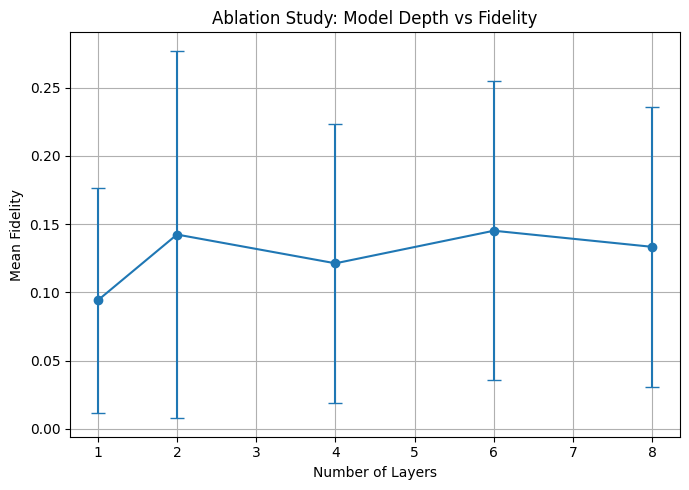

In [22]:
import matplotlib.pyplot as plt

def plot_ablation(df):
    plt.figure(figsize=(7, 5))

    plt.errorbar(
        df["n_layers"],
        df["mean_fidelity"],
        yerr=df["fidelity_std"],
        fmt="o-",
        capsize=5
    )

    plt.xlabel("Number of Layers")
    plt.ylabel("Mean Fidelity")
    plt.title("Ablation Study: Model Depth vs Fidelity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ablation(ablation_df)
